Wahlpflichtfach Künstliche Intelligenz II: Praktikum | [Startseite](index.ipynb) | [**<< 07 - Data Cleaning und Data Preparation**](07%20-%20Data%20Cleaning%20und%20Data%20Preparation.ipynb)

---

# 08 Scikit-learn - Data Preparation

__Scikit-learn__ (auch als __sklearn__ bekannt) ist ein Open-Source Software-Bibliotheke zum maschinellen Lernen in Python. Sie erfreut sich großer Beliebtheit und wird aktiv gewartet. Die Bibliothek bietet verschiedene Klassifikations-, Regressions- und Clustering-Algorithmen an. Darüber hinaus sind auch Algorithmen zur Modellauswahl, Dimensionsreduktion und Datenvorverarbeitung in sklearn enthalten. 

In diesem Noteboob beschäftigen wir uns (erneut) mit der Datenvorverarbeitung (Data Preparation) und gehen dabei auf die folgenden Themen ein:
- Imputation
- Skalierung
- Dimensionreduktion
- Pipelines
- Feature Union
- Column Transformations

Die Dokumentation zu scikit-learn ist [hier](https://scikit-learn.org/stable/index.html) zu finden.

In [1]:
import numpy as np
import pandas as pd
from sklearn import datasets
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

## Imputation
Unter Imputation ist das Vervollständigen von fehlenden Werten (NaNs) zu verstehen. Wie in pandas auch gibt es verschiedene Methoden um fehlende Werte in sklearn zu ersetzen. Weitere Informationen sind [hier](https://scikit-learn.org/stable/modules/impute.html) zu finde.

In [2]:
nan_data = np.array([[1, 2], [np.nan, 3], [7, 6]])

### Eindimensionale Imputation
In der eindimensonalen Imputation werden die Werte je Spalte ersetzt. Die Klasse [SimpleImputer](https://scikit-learn.org/stable/modules/generated/sklearn.impute.SimpleImputer.html#sklearn.impute.SimpleImputer) bietet dafür grundlegende Strategien. Fehlende Werte können mit einem bereitgestellten konstanten Wert oder mit statistischen Werten (Mittelwert, Median oder häufigster Wert) jeder Spalte, in der sich die fehlenden Werte befinden, ersetzt werden. Diese Klasse erlaubt auch verschiedene Kodierungen für fehlende Werte.

In [3]:
from sklearn.impute import SimpleImputer

# define different imputer
mean_imputer = SimpleImputer()
zero_imputer = SimpleImputer(strategy='constant', fill_value=0)

In [4]:
# First the imputer has to be fitted to the data, so either call first fit and then transform 
# or call fit_transform to do it in one step
mean_imputer.fit(nan_data)
mean_imputer.transform(nan_data)

array([[1., 2.],
       [4., 3.],
       [7., 6.]])

In [5]:
zero_imputer.fit_transform(nan_data)

array([[1., 2.],
       [0., 3.],
       [7., 6.]])

In [6]:
different_nan_data = np.array([[np.nan, 5], [8, 2], [6, 6]])
mean_imputer.transform(different_nan_data)

array([[4., 5.],
       [8., 2.],
       [6., 6.]])

__Brainstorming:__
<details>
<summary>Wieso wurde np.nan durch 4 ersetzt?</summary>
Da der mean_inputer zuvor auf den anderen Daten "trainiert" wurde. 
</details>

<details>
<summary>Wann kann dieses Verhalten von Vorteil sein?</summary>
Ein Vorteil ist es, dass die Ersetzungs-Strategien bzw. exakten Werte, die während des Trainings verwendet wurden, auch zur Test-Zeit bzw. im Live-Betrieb verwendet werden können. 
</details>

In [7]:
zero_imputer.transform(different_nan_data)

array([[0., 5.],
       [8., 2.],
       [6., 6.]])

Es ist auch möglich andere Werte als `np.nan` zu ersetzen. 

In [8]:
fischers_fritz = [['Fischers', '', 'fischt', 'frische', 'Fische'],
                  ['Frische', 'Fische', 'fischt', 'Fischers', '']]

string_imputer = SimpleImputer(missing_values='', strategy='constant', fill_value='Fritz')
string_imputer.fit_transform(fischers_fritz)          

array([['Fischers', 'Fritz', 'fischt', 'frische', 'Fische'],
       ['Frische', 'Fische', 'fischt', 'Fischers', 'Fritz']], dtype=object)

### Mehrdimensionale Variante
Die mehrdimensionalen Variante ist dahingegen deutlich anspruchsvoller. Grob zusammengefasst wird jeder fehlende Wert als Funktion anderer Merkmale modelliert und diese Schätzung zur Imputation verwendet. Dieser Vorgang wird dann einige Male wiederholt,, bevor die finalen Ersetzungen vorgenommen werden. Dieses Verhalten wird vom [IterativeImputer](https://scikit-learn.org/stable/modules/generated/sklearn.impute.IterativeImputer.html#sklearn.impute.IterativeImputer) implementiert. 

__Achtung:__ Diese Klasse ist noch experimentell 

In [9]:
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer

Zuerst erstellen wir uns ein kleines Dummy-Dataset, wo die Werte der einzelnen Spalten eine klare Beziehung zueinander haben. 

In [10]:
x = np.arange(1, 11, dtype=np.float)
y = x * x 
data = np.array([x, y])
data[(0, 1)] = np.nan
data[(0, 6)] = np.nan
data[(1, 3)] = np.nan
data[(1, 9)] = np.nan
data = data.T
data

/tmp/ipykernel_26704/508703242.py:1: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  x = np.arange(1, 11, dtype=np.float)


array([[ 1.,  1.],
       [nan,  4.],
       [ 3.,  9.],
       [ 4., nan],
       [ 5., 25.],
       [ 6., 36.],
       [nan, 49.],
       [ 8., 64.],
       [ 9., 81.],
       [10., nan]])

Anschließend können wir wieder mit `fit_transform` die Daten ersetzen.

In [11]:
IterativeImputer().fit_transform(data)

array([[ 1.        ,  1.        ],
       [ 2.3175117 ,  4.        ],
       [ 3.        ,  9.        ],
       [ 4.        , 22.35578423],
       [ 5.        , 25.        ],
       [ 6.        , 36.        ],
       [ 6.58808359, 49.        ],
       [ 8.        , 64.        ],
       [ 9.        , 81.        ],
       [10.        , 83.09539114]])

Die Ersetzungen des `SimpleImputer`s sehen hingegen folgendermaßen aus.

In [12]:
SimpleImputer().fit_transform(data)

array([[ 1.   ,  1.   ],
       [ 5.75 ,  4.   ],
       [ 3.   ,  9.   ],
       [ 4.   , 33.625],
       [ 5.   , 25.   ],
       [ 6.   , 36.   ],
       [ 5.75 , 49.   ],
       [ 8.   , 64.   ],
       [ 9.   , 81.   ],
       [10.   , 33.625]])

__Brainstorming:__
<details>
    <summary>Welche Vorteile bringt die mehrdimensionale Variante?</summary>
    Ein großer Vorteil ist, dass die nicht vorhandenen Daten abhängig von  anderen Daten ersetzt werden. Dies ist häufig besser, da es Abhängigkeiten zwischen den Daten geben kann. Beispiel: Größe und Gewicht von Personen.
</details>

In den folgenden drei Codezeilen, wird die iterative Arbeitsweise des Algorithmus sichtbar.

In [13]:
IterativeImputer(max_iter=1).fit_transform(data)

/home/delta/project/education/lectures/hsw/wpf-ii-ss2023/venv/lib64/python3.10/site-packages/sklearn/impute/_iterative.py:785: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(


array([[ 1.        ,  1.        ],
       [ 3.10315829,  4.        ],
       [ 3.        ,  9.        ],
       [ 4.        , 20.73213454],
       [ 5.        , 25.        ],
       [ 6.        , 36.        ],
       [ 6.8956479 , 49.        ],
       [ 8.        , 64.        ],
       [ 9.        , 81.        ],
       [10.        , 82.62527756]])

In [14]:
IterativeImputer(max_iter=2).fit_transform(data)

/home/delta/project/education/lectures/hsw/wpf-ii-ss2023/venv/lib64/python3.10/site-packages/sklearn/impute/_iterative.py:785: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(


array([[ 1.        ,  1.        ],
       [ 2.34645245,  4.        ],
       [ 3.        ,  9.        ],
       [ 4.        , 22.28201783],
       [ 5.        , 25.        ],
       [ 6.        , 36.        ],
       [ 6.61040064, 49.        ],
       [ 8.        , 64.        ],
       [ 9.        , 81.        ],
       [10.        , 83.06934333]])

In [15]:
IterativeImputer(max_iter=3).fit_transform(data)

array([[ 1.        ,  1.        ],
       [ 2.3175117 ,  4.        ],
       [ 3.        ,  9.        ],
       [ 4.        , 22.35578423],
       [ 5.        , 25.        ],
       [ 6.        , 36.        ],
       [ 6.58808359, 49.        ],
       [ 8.        , 64.        ],
       [ 9.        , 81.        ],
       [10.        , 83.09539114]])

## Skalierung

### Standardisierung
Unter Standardisiserung ist eine Transformation der Eingabedaten zu verstehen, so dass die resultierenden Daten eine Mittelwert von 0 und eine Varianz von 1 haben. Die resultierenden Daten sind also normalverteilt. Dies ist besonders hilfreich, wenn alle Variablen unterschiedlich skaliert sind. 

__Beispiel:__ Ein Datensatz enthält die Werte Größe in Metern und Gewicht in Kilogramm von Menschen. Die Varianz der Variablen wird deutlich unterschiedlich sein, da die Größe sich auf einer Skala von 0,1 m bis 2,8 m befindet und das Gewicht auf einer Skala von 0,5 kg bis 600 kg.

In sklearn wird für die Standardisierung die Klasse [StandardScaler](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html#sklearn.preprocessing.StandardScaler) verwendet. 

In [16]:
from sklearn.preprocessing import StandardScaler

scaling_data = np.array([[1.79, 79.5], 
                         [1.60, 53.2], 
                         [2.59, 150], 
                         [1.73, 70.7], 
                         [1.50, 46.7], 
                         [1.75, 113.0], 
                         [1.93, 247.2]])
print(f"Mittelwerte pro Feature: {scaling_data.mean(axis=0)}")
print(f"Standardabweichung pro Feature: {scaling_data.std(axis=0)}")

Mittelwerte pro Feature: [  1.84142857 108.61428571]
Standardabweichung pro Feature: [ 0.33090476 65.60408151]


In [17]:
scaler = StandardScaler()
scaled_data = scaler.fit_transform(scaling_data)
scaled_data

array([[-0.15541805, -0.44378772],
       [-0.72960139, -0.84467741],
       [ 2.26219602,  0.63084054],
       [-0.3367391 , -0.57792572],
       [-1.03180315, -0.94375661],
       [-0.27629875,  0.06685124],
       [ 0.26766441,  2.11245568]])

In [18]:
print(f"Mittelwerte pro Feature: {scaled_data.mean(axis=0)}")
print(f"Standardabweichung pro Feature: {scaled_data.std(axis=0)}")

Mittelwerte pro Feature: [-3.17206578e-17  6.34413157e-17]
Standardabweichung pro Feature: [1. 1.]


__Brainstorming:__
<details>
<summary>Wieso ist der Mittelwert nicht bei 0?</summary>
Das sind Berechnungsfehler, die vernachlässigt werden können. e-17 ist eine verdammt kleine Zahl.
</details>

Wenn die Daten nicht zentriert werden sollen, kann dies mit dem Parameter `with_mean=False` verhindert werden. 

In [19]:
not_center_scaler = StandardScaler(with_mean=False)
non_centric_data = not_center_scaler.fit_transform(scaling_data)

print(f"Mittelwerte pro Feature: {non_centric_data.mean(axis=0)}")
print(f"Standardabweichung pro Feature: {non_centric_data.std(axis=0)}")
non_centric_data

Mittelwerte pro Feature: [5.56482953 1.65560257]
Standardabweichung pro Feature: [1. 1.]


array([[5.40941148, 1.21181485],
       [4.83522814, 0.81092516],
       [7.82702555, 2.28644311],
       [5.22809043, 1.07767685],
       [4.53302638, 0.71184595],
       [5.28853078, 1.72245381],
       [5.83249394, 3.76805824]])

Ebenso ist es möglich die Daten nicht zu skalieren, um die Varianz zu behalten. Dafür muss der Konstruktor mit dem Parameter `with_std=False` aufgrufen werde.

In [20]:
not_scaling_scaler = StandardScaler(with_std=False)
non_scaled_data = not_scaling_scaler.fit_transform(scaling_data)

print(f"Mittelwerte pro Feature: {non_scaled_data.mean(axis=0)}")
print(f"Standardabweichung pro Feature: {non_scaled_data.std(axis=0)}")
non_scaled_data

Mittelwerte pro Feature: [0. 0.]
Standardabweichung pro Feature: [ 0.33090476 65.60408151]


array([[-5.14285714e-02, -2.91142857e+01],
       [-2.41428571e-01, -5.54142857e+01],
       [ 7.48571429e-01,  4.13857143e+01],
       [-1.11428571e-01, -3.79142857e+01],
       [-3.41428571e-01, -6.19142857e+01],
       [-9.14285714e-02,  4.38571429e+00],
       [ 8.85714286e-02,  1.38585714e+02]])

### Skalierung der Features in einem bestimmten Bereich
Alternativ kann die Skalierung von Featuren so erfolgen, dass sie zwischen einem vorgegebenen Minimal- und Maximalwert liegen, oft zwischen Null und Eins, oder so, dass der maximale Absolutwert jedes Features auf Einheitsgröße skaliert wird. Dies kann mit [MinMaxScaler](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.MinMaxScaler.html#) bzw. [MaxAbsScaler](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.MaxAbsScaler.html#) erreicht werden. 

In [21]:
from sklearn.preprocessing import MinMaxScaler
min_max_data = np.array([[-1, 2], 
                         [-0.5, 6], 
                         [0, 10], 
                         [1, 18]])

zero_one_scaler = MinMaxScaler()
zero_one_scaler.fit_transform(min_max_data)

array([[0.  , 0.  ],
       [0.25, 0.25],
       [0.5 , 0.5 ],
       [1.  , 1.  ]])

Um den Bereich zu ändern kann im Konstruktor der Parameter `feature_range` spezifiziert werden.

In [22]:
minus_one_one_scaler = MinMaxScaler(feature_range=(-1, 1))
minus_one_one_scaler.fit_transform(min_max_data)

array([[-1. , -1. ],
       [-0.5, -0.5],
       [ 0. ,  0. ],
       [ 1. ,  1. ]])

In [23]:
from sklearn.preprocessing import MaxAbsScaler
max_abs_data = np.array([[ 1., -1.,  2.],
                         [ 2.,  0.,  0.],
                         [ 0.,  1., -1.]])

max_abs_scaler = MaxAbsScaler()
max_abs_scaler.fit_transform(max_abs_data)

array([[ 0.5, -1. ,  1. ],
       [ 1. ,  0. ,  0. ],
       [ 0. ,  1. , -0.5]])

### Probleme mit Ausreißern
Die drei vorgestellten Klassen können bei der Skalierung nicht besonders gut mit Ausreißern (outlier) umgehen. Dieses Problem wird [hier](https://scikit-learn.org/stable/auto_examples/preprocessing/plot_all_scaling.html#sphx-glr-auto-examples-preprocessing-plot-all-scaling-py) dargestellt.

Ein Skaler, der mit Ausreißern funktioniert ist der [RobustScaler](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.RobustScaler.html). 

In [24]:
from sklearn.preprocessing import RobustScaler
outlier_data = np.array([[2, 4, 1, 27, 3, 4, 1, 3, 3, 2],
                [100, 92, 87, 94, 95, 83, 177, 84, 99, 89]]).T

robust_scaler = RobustScaler(quantile_range=(25, 75))
robust_scaler.fit_transform(outlier_data)

array([[-0.57142857,  0.66666667],
       [ 0.57142857, -0.0952381 ],
       [-1.14285714, -0.57142857],
       [13.71428571,  0.0952381 ],
       [ 0.        ,  0.19047619],
       [ 0.57142857, -0.95238095],
       [-1.14285714,  8.        ],
       [ 0.        , -0.85714286],
       [ 0.        ,  0.57142857],
       [-0.57142857, -0.38095238]])

In [25]:
robust_scaler.scale_

array([ 1.75, 10.5 ])

In [26]:
robust_scaler.center_

array([ 3., 93.])

Im Vergleich dazu würde der StandardScaler die Daten folgendermaßen skalieren.

In [27]:
StandardScaler().fit_transform(outlier_data)

array([[-0.40525742,  0.        ],
       [-0.13508581, -0.30477573],
       [-0.54034323, -0.49526056],
       [ 2.97188775, -0.2285818 ],
       [-0.27017161, -0.19048483],
       [-0.13508581, -0.64764842],
       [-0.54034323,  2.93346637],
       [-0.27017161, -0.60955145],
       [-0.27017161, -0.03809697],
       [-0.40525742, -0.41906662]])

__Aufgabe:__ 
<details>
<summary>Wie werden die neuen Werte berechnet?</summary>
Zuerst müssen der Median und die Quantile pro Spalte bestimmt werden. Dann können die neuen Werte wie folgt berechnet werden:
    $$x_{neu} = \frac{x_{alt} - median}{quantile_{upper} - quantil_{lower}}$$
</details>

## Dimensionsreduktion
Unter Dimensionsreduktion ist die Reduzierung der Anzahl der Zufallsvariablen zu verstehen. Dies kann sowohl für die Visualisierung als auch fürs maschinelle Lernen hilfreich sein.

Im Folgendem werden wir den Iris-Datensatz (Iris = Schwertlilie) verwenden. Er besteht aus 4 Features (Sepal Länge, Sepal Breite, Petal Länge und Petal Breite) und hat 3 Klassen. 

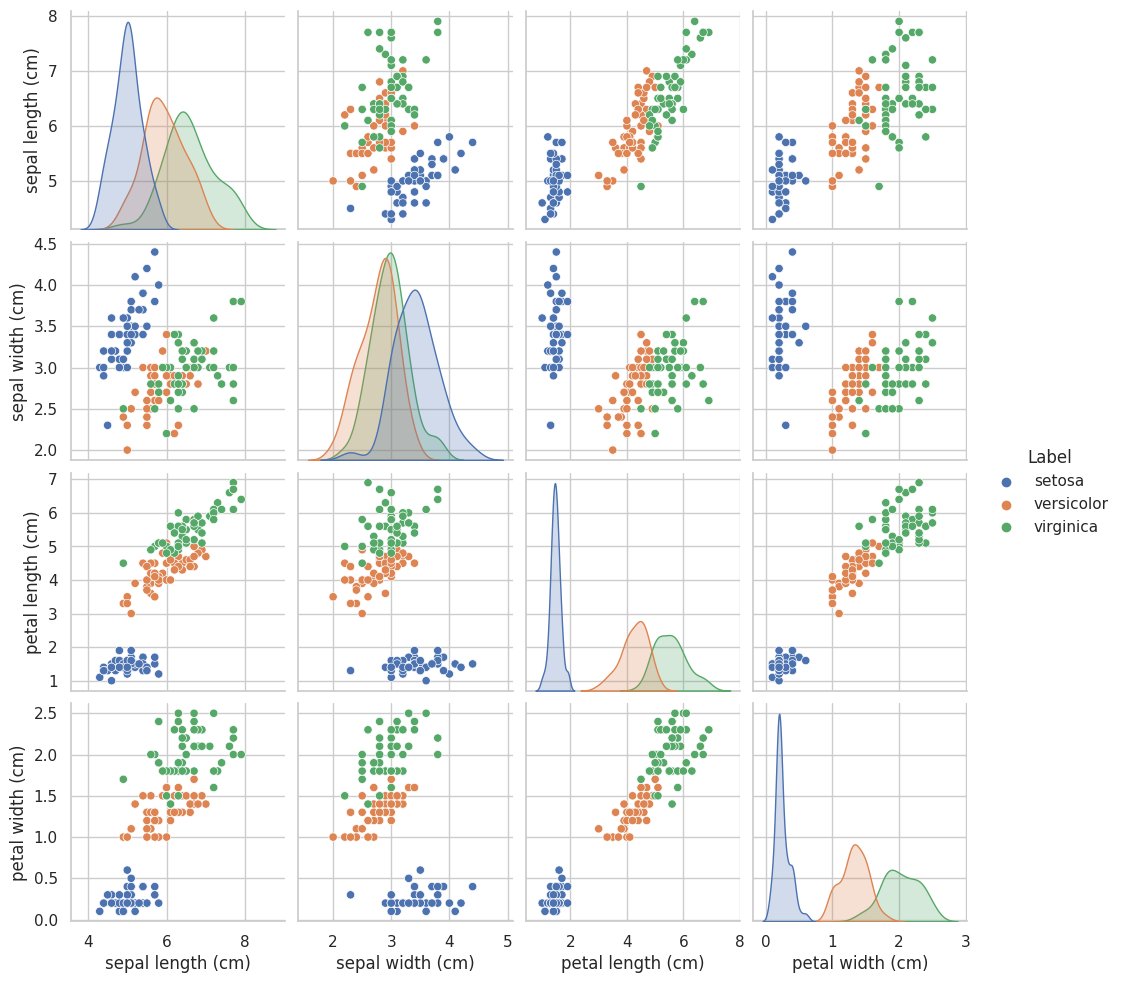

In [28]:
iris = datasets.load_iris(as_frame=True)
iris_df = iris.frame
iris_df['Label'] = iris.target_names[iris_df['target']]
iris_df = iris_df.drop('target', axis=1)

sns.set_theme(style="whitegrid")
sns.pairplot(iris_df, hue="Label")

### Principial Component Analyse (PCA)
PCA wird verwendet, um einen multidimensionalen Datensatz in eine Menge von aufeinanderfolgenden orthogonalen Komponenten zu zerlegen, die einen maximalen Anteil der Varianz erklären. Wie auch die vorherigen Algorithmen ist [PCA](https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html) als Transformer-Objekt implementiert. Das heißt es muss erst mit `fit()` trainiert werden. Anschließend kann es dann auf die Daten angewandt werden und die $n$ Feature finde, die den größten Anteil der Varainz in den Daten erklären.

Text(0, 0.5, 'Dimension 2')

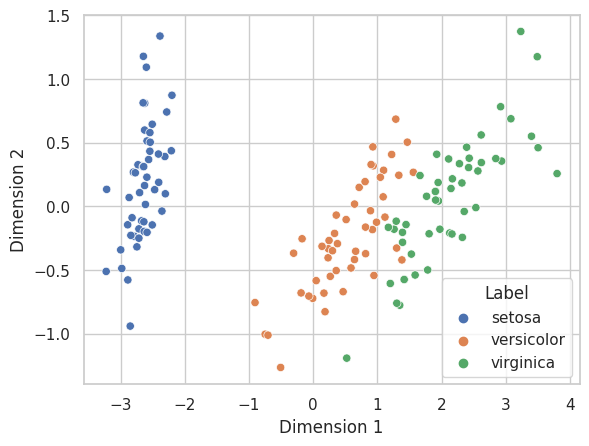

In [29]:
from sklearn.decomposition import PCA

# we want to have the two components with the highest variance
pca = PCA(n_components=2)
pca.fit(iris.data)
reduced_iris = pca.transform(iris.data)

# show the two components with the highest variance
ax_pca = sns.scatterplot(x=reduced_iris[:, 0], y=reduced_iris[:, 1], hue=iris_df['Label'])
ax_pca.set_xlabel('Dimension 1')
ax_pca.set_ylabel('Dimension 2')

__Brainstorming:__
<details>
<summary>Was könnte eine Schwäche von PCA im Kontext einer Klassifikationsaufgabe sein?</summary>
PCA versucht die größte Varianz in der Gesamtheit der Daten zu finden. Dabei beachtet PCA aber nicht die Varianz zwischen den einzelnen Klassen. Dies kann dazu führen, dass suboptimale Features für die Klassifizeirung ausgewählt werden. 
</details>

### Linear Discriminant Analysis (LDA)
[LDA]() verwendet im Gegensatz zu PCA auch die Klassenzugehörigkeit. Dabei versucht es die Features zu ermitteln, die den größten Einfluss auf die Varianz zwischen den Klassen haben. Da LDA die Klassenzugehörigkeit verwendet, handelt es sich dabei um eine supervised Methode. 

Text(0, 0.5, 'Dimension 2')

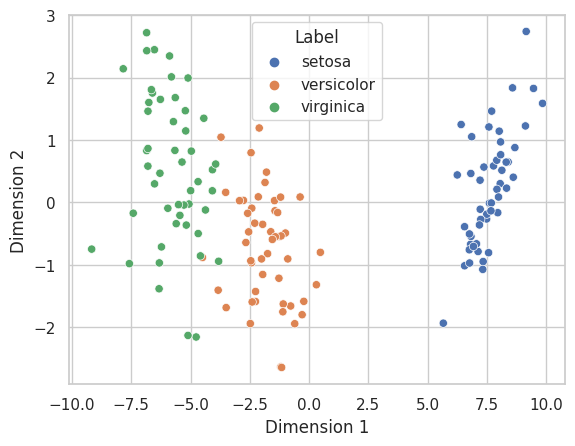

In [30]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

lda = LinearDiscriminantAnalysis(n_components=2)
lda.fit(iris.data, iris.target)
lda_reduced_iris = lda.transform(iris.data)

# show the two components with the highest variance between classes
ax_lda = sns.scatterplot(x=lda_reduced_iris[:, 0], y=lda_reduced_iris[:, 1], hue=iris_df['Label'])
ax_lda.set_xlabel('Dimension 1')
ax_lda.set_ylabel('Dimension 2')

### Vergleich von PCA und LDA

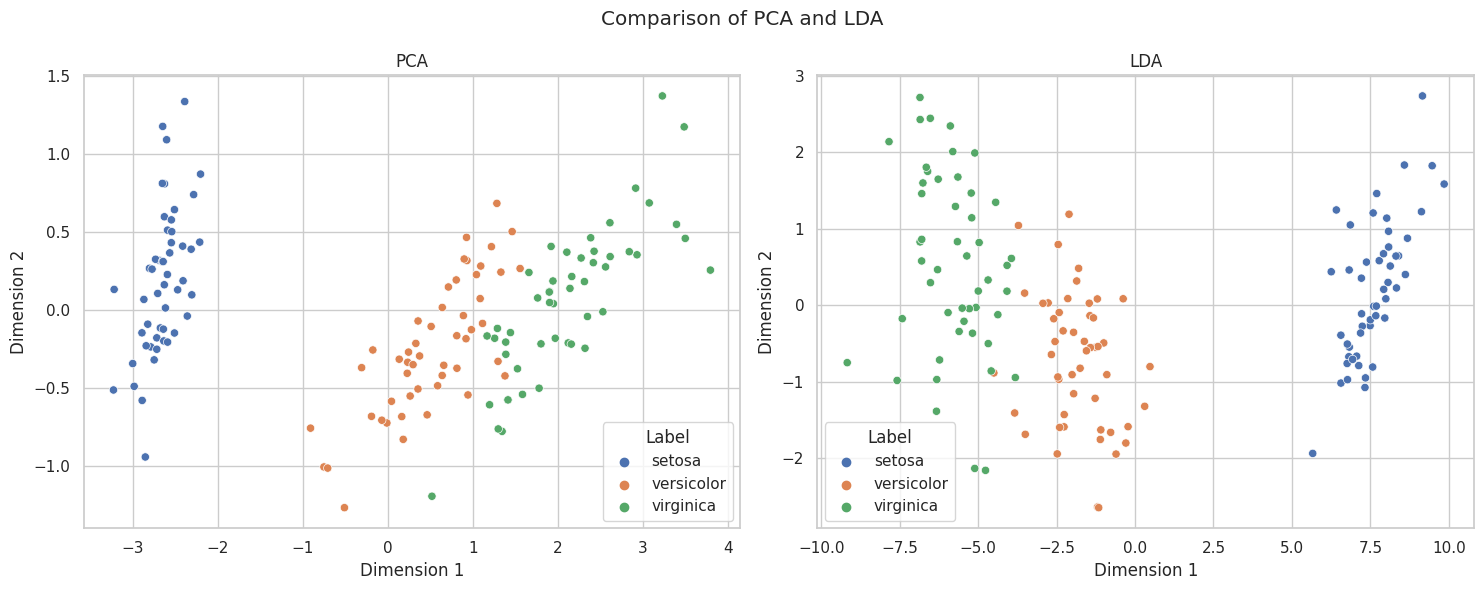

In [31]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15,6))
sns.scatterplot(x=reduced_iris[:, 0], y=reduced_iris[:, 1], hue=iris_df['Label'], ax=ax1)
ax1.set_xlabel('Dimension 1')
ax1.set_ylabel('Dimension 2')
ax1.set_title('PCA')
sns.scatterplot(x=lda_reduced_iris[:, 0], y=lda_reduced_iris[:, 1], hue=iris_df['Label'], ax=ax2)
ax2.set_xlabel('Dimension 1')
ax2.set_ylabel('Dimension 2')
ax2.set_title('LDA')
fig.suptitle('Comparison of PCA and LDA')
fig.tight_layout()

## Pipelines
[Pipeline](https://scikit-learn.org/stable/modules/generated/sklearn.pipeline.Pipeline.html) kann verwendet werden, um mehrere Kalkulatoren zu einem zu verketten. Dies ist nützlich, da es oft eine feste Abfolge von Schritten bei der Verarbeitung der Daten gibt, z. B. Merkmalsauswahl, Normalisierung und Klassifizierung. Pipeline dient hier mehreren Zwecken:

1) __Bequemlichkeit und Verkapselung__
> Sie müssen `fit` und `predict` nur einmal auf Ihren Daten aufrufen, um eine ganze Sequenz von Kalkulatoren anzupassen.

2) __Gemeinsame Parameterauswahl__
> Sie können eine Rastersuche (Grid Search) über die Parameter aller Kalkulatoren in der Pipeline auf einmal durchführen. Darauf gehen wir später weiter ein.

3) __Sicherheit__
> Pipelines helfen dabei, ein Durchsickern von Statistiken aus Ihren Testdaten in das trainierte Modell bei der Kreuzvalidierung (darauf gehen wir auch später noch ein) zu vermeiden, indem sichergestellt wird, dass die gleichen Stichproben zum Trainieren der Transformatoren und Vorhersager verwendet werden.

Alle Kalkulatoren in einer Pipeline, außer dem letzten, müssen Transformatoren sein (d. h. sie müssen eine `transform`-Methode haben). Der letzte Kalkulatoren kann ein beliebiger Typ sein (Transformator, Klassifikator usw.).

### Konstruktor
Die [Pipeline](https://scikit-learn.org/stable/modules/generated/sklearn.pipeline.Pipeline.html) wird mit einer Liste von (Schlüssel, Wert)-Paaren aufgebaut, wobei der Schlüssel eine Zeichenkette ist, die den Namen enthält, den Sie diesem Schritt geben möchten, und der Wert ein Kalkulator ist.

In [32]:
from sklearn.pipeline import Pipeline

# first, create a dictionary with all the estimators we want to have in the pipeline, each step needs a name
estimators = [('imputer', SimpleImputer()), ('scaler', StandardScaler())]

# then, pass the estimators to the Pipeline constructor
pipe = Pipeline(estimators)
pipe

Pipeline(steps=[('imputer', SimpleImputer()), ('scaler', StandardScaler())])

In [33]:
# if you don't want to name the estimators explicit you can use the make_pipeline function
from sklearn.pipeline import make_pipeline
make_pipeline(SimpleImputer(), StandardScaler())

Pipeline(steps=[('simpleimputer', SimpleImputer()),
                ('standardscaler', StandardScaler())])

### Parameter der Kalkulatoren setzen
Auf die Parameter der Kalkulatoren in der Pipeline kann mit der Syntax `<estimator>__<parameter>` (_2 Unterstriche_) zugegriffen werden.

In [34]:
pipe.set_params(imputer__strategy='constant', imputer__fill_value=0)

Pipeline(steps=[('imputer', SimpleImputer(fill_value=0, strategy='constant')),
                ('scaler', StandardScaler())])

Nachdem die Parameter gesetzt wurden können wir die Pipeline mit dummy-Werten testen. 

In [35]:
pipe_data = [[1, 4], [5, 8], [np.nan, 5], [3, np.nan]]
pipe.fit_transform(pipe_data)

array([[-0.65094455, -0.08737041],
       [ 1.43207802,  1.31055608],
       [-1.1717002 ,  0.26211122],
       [ 0.39056673, -1.4852969 ]])

Um andere Parameter zu verwenden, müssen diese wieder mit `set_params()` gesetzt werden.

In [36]:
# reset to default parameters
pipe.set_params(imputer__strategy='mean', imputer__fill_value=None)

Pipeline(steps=[('imputer', SimpleImputer()), ('scaler', StandardScaler())])

In [37]:
pipe.fit_transform(pipe_data)

array([[-1.41421356, -1.13227703],
       [ 1.41421356,  1.58518785],
       [ 0.        , -0.45291081],
       [ 0.        ,  0.        ]])

Des Weiteren ist es möglich auch einzelne Schritte komplett zu ersetzen. Dazu wird ebenfalls wieder `set_params()` verwendet und der Name des Schrittes angegeben, der ersetzt werden soll.

In [38]:
pipe.set_params(scaler=MaxAbsScaler())

Pipeline(steps=[('imputer', SimpleImputer()), ('scaler', MaxAbsScaler())])

In [39]:
pipe.fit_transform(pipe_data)

array([[0.2       , 0.5       ],
       [1.        , 1.        ],
       [0.6       , 0.625     ],
       [0.6       , 0.70833333]])

Wenn ein Schritt in der Pipeline nicht mehr ausgeführt werden soll, kann dies durch das Übergeben des Wertes `'passthrough'` erreicht werden.

In [40]:
pipe.set_params(scaler='passthrough')

Pipeline(steps=[('imputer', SimpleImputer()), ('scaler', 'passthrough')])

In [41]:
pipe.fit_transform(pipe_data)

array([[1.        , 4.        ],
       [5.        , 8.        ],
       [3.        , 5.        ],
       [3.        , 5.66666667]])

## Feature Union
[FeatureUnion](https://scikit-learn.org/stable/modules/generated/sklearn.pipeline.FeatureUnion.html) kombiniert mehrere Transformator-Objekte zu einem neuen Transformator, der deren Ausgabe kombiniert. Eine FeatureUnion nimmt eine Liste von Transformator-Objekten auf. Während der Anpassung wird jeder von ihnen unabhängig an die Daten angepasst. Die Transformatoren werden parallel angewendet und die von ihnen ausgegebenen Feature-Matrizen werden nebeneinander zu einer größeren Matrix verkettet.

### Konstruktor
Eine FeatureUnion wird aus einer Liste von (Schlüssel, Wert)-Paaren aufgebaut, wobei der Schlüssel der Name ist, den Sie einer gegebenen Transformation geben möchten und der Wert ein Kalkulator ist.

In [42]:
from sklearn.pipeline import FeatureUnion
from sklearn.decomposition import KernelPCA

estimators = [('linear_pca', PCA()), ('kernel_pca', KernelPCA())]
combined = FeatureUnion(estimators)
combined

FeatureUnion(transformer_list=[('linear_pca', PCA()),
                               ('kernel_pca', KernelPCA())])

Auch hier ist es wieder möglich die Schritte nicht explizit zu benennen. Dafür kann die Methode `make_union()` verwendet werden.

In [43]:
from sklearn.pipeline import make_union
make_union(PCA(), KernelPCA())

FeatureUnion(transformer_list=[('pca', PCA()), ('kernelpca', KernelPCA())])

In [44]:
combined_data = [[1, 4, 3], [5, 8, 7], [2, 5, 4], [3, 6, 5]]
combined.fit_transform(combined_data)

array([[-3.03108891e+00,  3.02620036e-16, -0.00000000e+00,
        -3.03108891e+00],
       [ 3.89711432e+00,  2.17973424e-16,  0.00000000e+00,
         3.89711432e+00],
       [-1.29903811e+00, -4.24413644e-17,  0.00000000e+00,
        -1.29903811e+00],
       [ 4.33012702e-01,  2.92553432e-17,  0.00000000e+00,
         4.33012702e-01]])

### Parameter der Transformer setzen
Auch hier können die Parameter der Transformer wieder über die Methode `set_params()` gesetzt werden. 

In [45]:
combined.set_params(linear_pca__n_components=3)

FeatureUnion(transformer_list=[('linear_pca', PCA(n_components=3)),
                               ('kernel_pca', KernelPCA())])

Um einen Schritt zu ignorieren muss an den entsprechenden Schrittname der Wert `'drop'` übergeben werden.

In [46]:
combined.set_params(kernel_pca='drop')

FeatureUnion(transformer_list=[('linear_pca', PCA(n_components=3)),
                               ('kernel_pca', 'drop')])

## Column Transformations
Viele Datensätze enthalten Merkmale verschiedener Typen, z. B. Text, Fließkommazahlen und Datumsangaben, wobei jeder Merkmalstyp separate Vorverarbeitungs- oder Featureextraktionsschritte erfordert. Oft ist es am einfachsten, die Daten vor der Anwendung von scikit-learn-Methoden vorzuverarbeiten, zum Beispiel mit __Pandas__. 

Allerdings kann die Verarbeitung der Daten vor der Übergabe an scikit-learn aus einem der folgenden Gründe problematisch sein:
1) Das Einbeziehen von Statistiken aus Testdaten in die Präprozessoren macht die Ergebnisse der Kreuzvalidierung unzuverlässig (bekannt als Datenleck), zum Beispiel im Fall von Skalierern oder der Imputierung fehlender Werte.

2) Sie möchten möglicherweise die Parameter der Vorverarbeitung in eine Parametersuche einbeziehen.

Der [ColumnTransformer](https://scikit-learn.org/stable/modules/generated/sklearn.compose.ColumnTransformer.html) hilft bei der Durchführung verschiedener Transformationen für verschiedene Spalten der Daten, innerhalb einer Pipeline, die sicher vor Datenlecks ist und die parametrisiert werden kann.

### Dummy-Daten erstellen
Zuerst erstellen wir uns ein Datensatz der neben nummerischen Daten auch Text enthält.

In [47]:
book_data_raw = pd.DataFrame(
    {
        'city': ['London', 'London', 'Paris', 'Sallisaw'],
        'title': ["His Last Bow", "How Watson Learned the Trick", "A Moveable Feast", "The Grapes of Wrath"],
        'expert_rating': [5, 3, 4, 5],
        'user_rating': [4, 5, 4, 3]
    }
)

__Brainstorming:__

<details>
<summary>Wie können wir die Textdaten verwenden?</summary>
Um die Textdaten fürs maschinelle Lernen zu verwenden müssen diese in Zahlen umgewandelt werden. In diesem Fall kann die Stadt beispielsweise One-Hot encoded werden und für den Titel können wir die vorkommenden Wörter zählen (im Seminar werden wir noch genauer darauf eingehen).
</details>

### Konstruktor
Wir wollen auf die Spalte `'city'` den [OneHotEncoder](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.OneHotEncoder.html#sklearn.preprocessing.OneHotEncoder) anwenden und auf die Spalte `'title'` den [CountVectorizer](https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.CountVectorizer.html#sklearn.feature_extraction.text.CountVectorizer). 

In [48]:
from sklearn.compose import ColumnTransformer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.preprocessing import OneHotEncoder
column_trans = ColumnTransformer([('city_category', OneHotEncoder(dtype='int'),['city']),
                                  ('title_bow', CountVectorizer(), 'title')])

column_trans.fit(book_data_raw) 

ColumnTransformer(transformers=[('city_category', OneHotEncoder(dtype='int'),
                                 ['city']),
                                ('title_bow', CountVectorizer(), 'title')])

Die Namen der Features bekommt man über die Methode `get_feature_names()`.

In [50]:
column_trans.get_feature_names_out()

array(['city_category__city_London', 'city_category__city_Paris',
       'city_category__city_Sallisaw', 'title_bow__bow',
       'title_bow__feast', 'title_bow__grapes', 'title_bow__his',
       'title_bow__how', 'title_bow__last', 'title_bow__learned',
       'title_bow__moveable', 'title_bow__of', 'title_bow__the',
       'title_bow__trick', 'title_bow__watson', 'title_bow__wrath'],
      dtype=object)

In [51]:
column_trans.transform(book_data_raw).toarray()

array([[1, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0],
       [1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 1, 1, 0],
       [0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0],
       [0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1]])

Alle Features, die nicht an einen Transformator übergeben wurden, werden defaultmäßig nicht mit ausgegeben. Um dieses Verhalten zu verändern, kann dem Konstruktor ein Wert für den Parameter `remainder` übergeben werden.  

In [52]:
column_trans = ColumnTransformer([('city_category', OneHotEncoder(dtype='int'),['city']),
                                  ('title_bow', CountVectorizer(), 'title')],
                                remainder='passthrough')

column_trans.fit(book_data_raw)

ColumnTransformer(remainder='passthrough',
                  transformers=[('city_category', OneHotEncoder(dtype='int'),
                                 ['city']),
                                ('title_bow', CountVectorizer(), 'title')])

In [53]:
column_trans.get_feature_names_out()

array(['city_category__city_London', 'city_category__city_Paris',
       'city_category__city_Sallisaw', 'title_bow__bow',
       'title_bow__feast', 'title_bow__grapes', 'title_bow__his',
       'title_bow__how', 'title_bow__last', 'title_bow__learned',
       'title_bow__moveable', 'title_bow__of', 'title_bow__the',
       'title_bow__trick', 'title_bow__watson', 'title_bow__wrath',
       'remainder__expert_rating', 'remainder__user_rating'], dtype=object)

In [54]:
column_trans.transform(book_data_raw)

array([[1, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 5, 4],
       [1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 1, 1, 0, 3, 5],
       [0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 4, 4],
       [0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 5, 3]])

Auch hier gibt es wieder die Möglichkeit, die Namen für die einzelnen Schritte nicht explizit zu vergeben. Dafür kann die Methode `make_column_transformer()` verwendet werden. Außerdem kann man auch einen Transformer an den Parameter `remainder` übergeben. Dieser wird dann auf alle übrigen Spalten angewandt.  

In [ ]:
from sklearn.compose import make_column_transformer
column_trans = make_column_transformer(
    (OneHotEncoder(), ['city']),
    (CountVectorizer(), 'title'),
    remainder=MinMaxScaler()
)
column_trans

In [ ]:
column_trans.fit_transform(book_data_raw)

## Generelle Funktionsweise
Wie Ihr bestimmt bereits bemerkt habt sind die Schritte immer wieder die gleichen:
1. __Konstruktor:__ Erstellen des Algorithmus. Die meisten Algorithmen können in diesem Schritt parametrisiert werden.
2. __fit():__ Training des Algorithmus anhand der übergebenden Daten.
3. __transform():__ Mit der `transform()`-Methode kann der Agorithmus anschließend die Transformationen für die übergebenen Werte druchführen.

---

Wahlpflichtach Künstliche Intelligenz II: Praktikum | [Startseite](index.ipynb) | [**>> 09 Scikit-learn - Maschinelles Lernen**](09%20-%20Scikit-learn%20-%20Maschinelles%20Lernen.ipynb)